In [1]:
import numpy as np
import pandas as pd
from grabscreen import grab_screen
import cv2
import time
from directkeys import PressKey,ReleaseKey, W, A, S, D
from models import inception_v3 as googlenet
from getkeys import key_check
from collections import deque, Counter
import random
from statistics import mode,mean
import numpy as np
#from motion import motion_detection
GAME_WIDTH = 1920
GAME_HEIGHT = 1080
how_far_remove = 800
rs = (20,15)
log_len = 25
motion_req = 800
motion_log = deque(maxlen=log_len)
WIDTH = 480
HEIGHT = 270
LR = 1e-3
EPOCHS = 1
choices = deque([], maxlen=5)
hl_hist = 250
choice_hist = deque([], maxlen=hl_hist)
w = [1,0,0,0,0,0,0,0,0]
s = [0,1,0,0,0,0,0,0,0]
a = [0,0,1,0,0,0,0,0,0]
d = [0,0,0,1,0,0,0,0,0]
wa = [0,0,0,0,1,0,0,0,0]
wd = [0,0,0,0,0,1,0,0,0]
sa = [0,0,0,0,0,0,1,0,0]
sd = [0,0,0,0,0,0,0,1,0]
nk = [0,0,0,0,0,0,0,0,1]


Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#Importing Gamepad library
from vjoy2 import *

In [3]:
#Definitions of the keyboard

In [4]:
t_time = 0.25
def straight():
    PressKey(W)
    ReleaseKey(A)
    ReleaseKey(D)
    ReleaseKey(S)

def left():
    if random.randrange(0,3) == 1:
        PressKey(W)
    else:
        ReleaseKey(W)
    PressKey(A)
    ReleaseKey(S)
    ReleaseKey(D)
    #ReleaseKey(S)

def right():
    if random.randrange(0,3) == 1:
        PressKey(W)
    else:
        ReleaseKey(W)
    PressKey(D)
    ReleaseKey(A)
    ReleaseKey(S)
    
def reverse():
    PressKey(S)
    ReleaseKey(A)
    ReleaseKey(W)
    ReleaseKey(D)


def forward_left():
    PressKey(W)
    PressKey(A)
    ReleaseKey(D)
    ReleaseKey(S)
    
    
def forward_right():
    PressKey(W)
    PressKey(D)
    ReleaseKey(A)
    ReleaseKey(S)
    
def reverse_left():
    PressKey(S)
    PressKey(A)
    ReleaseKey(W)
    ReleaseKey(D)
    
def reverse_right():
    PressKey(S)
    PressKey(D)
    ReleaseKey(W)
    ReleaseKey(A)

def no_keys():
    if random.randrange(0,3) == 1:
        PressKey(W)
    else:
        ReleaseKey(W)
    ReleaseKey(A)
    ReleaseKey(S)
    ReleaseKey(D)

In [5]:
model = googlenet(WIDTH, HEIGHT, 3, LR, output=29)
MODEL_NAME = 'model_clean/test'

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.load(MODEL_NAME)
print('We have loaded a previous model!!!!')

INFO:tensorflow:Restoring parameters from C:\Users\rusla\Dropbox\23-GITHUB\Projects\BOT-MMORPG-WITH-AI\versions\0.01\model_clean\test
We have loaded a previous model!!!!


# Analysis of the prediction

In [7]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image
from matplotlib import pyplot as plt
from numpy import load

In [8]:
def showarray(a, fmt='jpeg'):
    a_n = np.uint8(np.clip(a, 0, 255))
    try :
        f = io.BytesIO()
        PIL.Image.fromarray(a_n).save(f, fmt)
        display(Image(data=f.getvalue()))
    except:
        #a = a[:, :, ::-1] # convert image from RGB (skimage) to BGR (opencv)
        # display image   
        plt.imshow(a)
        plt.show()  

In ordering to use the machine learning model, the original screenshot from our computer should be processed in a propper way, such a way can be recognized by our Neural Network.
The steps of the processing part are the follow:

1. Raw image -It is obtained the raw image 
2. Separation into rgb colors
3. First resize (270, 480, 3)
4. Reshape to shape (480, 270, 3), ie screen_reshaped=screen.reshape(WIDTH,HEIGHT,3)
After is reshaped the prediction is done by creating a list, the elements are placed inside square brackets 
5. input=[screen_reshaped]
   prediction = model.predict(input)[0]
   

In [62]:
last_time = time.time()
for i in list(range(4))[::-1]:
    print(i+1)
    time.sleep(1)
paused = False
mode_choice = 0

#Image step 1 - Raw image -It is obtained the raw image 
#screen = grab_screen(region=(0,40,GAME_WIDTH,GAME_HEIGHT+40))
# load array
screen  = cv2.imread('test.png',1)

#Image step 2 - separation into rgb colors
screen = cv2.cvtColor(screen, cv2.COLOR_BGR2RGB)



prev = cv2.resize(screen, (WIDTH,HEIGHT))

t_minus = prev
t_now = prev
t_plus = prev

4
3
2
1


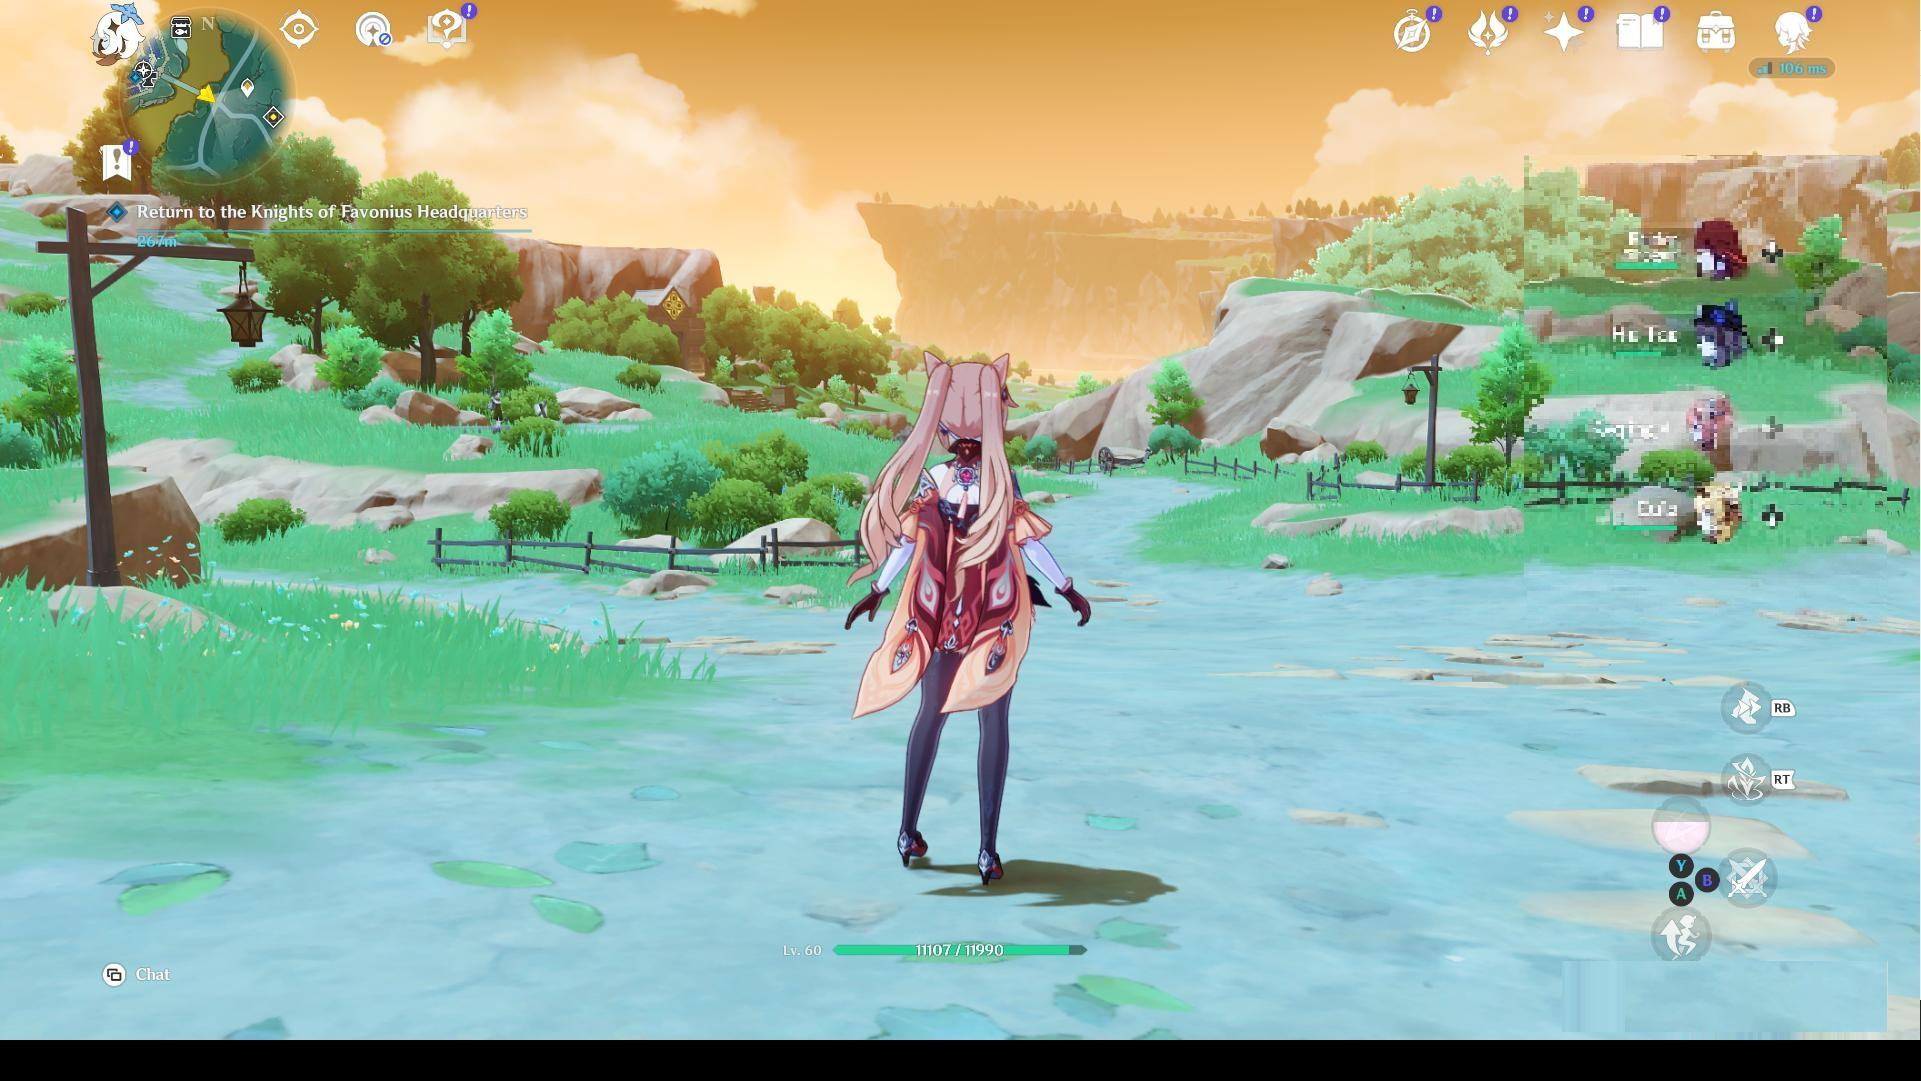

In [10]:
# The capture of the screen should be something like this
showarray(screen)

In [61]:
screen.shape
#(270, 480, 3)

(270, 480, 3)

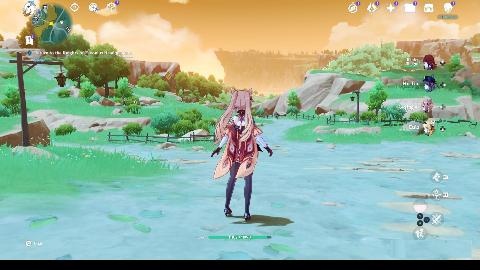

In [65]:
last_time = time.time()
#Image step 3 - First resize
screen = cv2.resize(screen, (WIDTH,HEIGHT))
# It is resized the screen
showarray(screen)

In [66]:
screen.shape
#(270, 480, 3)

(270, 480, 3)

In [67]:
#The capture of the screen should be something like this

In [68]:
import cv2

def delta_images(t0, t1, t2):
    d1 = cv2.absdiff(t2, t0)
    return d1

def motion_detection(t_minus, t_now, t_plus):
    delta_view = delta_images(t_minus, t_now, t_plus)
    retval, delta_view = cv2.threshold(delta_view, 16, 255, 3)
    cv2.normalize(delta_view, delta_view, 0, 255, cv2.NORM_MINMAX)
    img_count_view = cv2.cvtColor(delta_view, cv2.COLOR_RGB2GRAY)
    delta_count = cv2.countNonZero(img_count_view)
    dst = cv2.addWeighted(screen,1.0, delta_view,0.6,0)
    delta_count_last = delta_count
    return delta_count

In [69]:
print(len(t_minus), len(t_now), len(t_plus))

270 270 270


In [70]:
delta_count_last = motion_detection(t_minus, t_now, t_plus)

In [73]:
t_minus = t_now
t_now = t_plus
t_plus = screen
#Step 3 Filter blur
t_plus = cv2.blur(t_plus,(4,4))

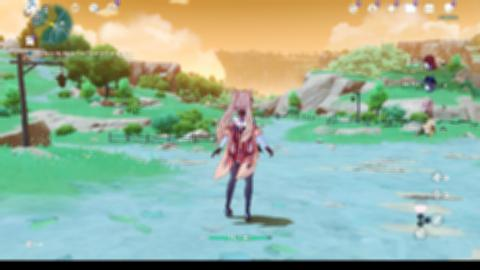

In [74]:
showarray(t_plus)

In [81]:
#Step 4  Reshape to (480, 270, 3)
screen.reshape(WIDTH,HEIGHT,3).shape

(480, 270, 3)

In [18]:
prediction = model.predict([screen.reshape(WIDTH,HEIGHT,3)])[0]

In [19]:
prediction=prediction.round(decimals=2, out=None)
prediction

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.46, 0.  , 0.  ,
       0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)

In [20]:
columns=['W', 'S', 'A', 'D', 'WA', 'WD', 'SA', 'SD',' NOKEY','LT', 'RT', 'Lx', 'Ly', 'Rx', 'Ry', 'UP', 'DOWN', 'LEFT', 'RIGHT',
       'START', 'SELECT', 'L3', 'R3', 'LB', 'RB', 'A', 'B', 'X', 'Y']

In [21]:
len(columns)

29

In [22]:
dato=np.array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.46, 0.  , 0.  ,
       0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])
columna=['W', 'S', 'A', 'D', 'WA', 'WD', 'SA', 'SD',' NOKEY','LT', 'RT', 'Lx', 'Ly', 'Rx', 'Ry', 'UP', 'DOWN', 'LEFT', 'RIGHT',
       'START', 'SELECT', 'L3', 'R3', 'LB', 'RB', 'A', 'B', 'X', 'Y']

df_pred = pd.DataFrame(dato,
                   columns=columna)
df_pred_transposed = df_pred.T 

In [23]:
dato.shape

(1, 29)

In [24]:
df_pred_transposed 

,0
W,0.00
S,0.00
A,0.00
D,0.00
WA,0.00
WD,0.00
SA,0.00
SD,0.00
NOKEY,0.46
LT,0.00


In the previous code we have seen the prediction of our neural network, it is a numpy.ndarray with 29 elements of the input

In [25]:
len([4.5, 0.1, 0.1, 0.1,  1.8,   1.8, 0.5, 0.5, 0.2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

29

In [26]:
prediction = np.array(prediction) * np.array([4.5, 0.1, 0.1, 0.1,  1.8,   1.8, 0.5, 0.5, 0.2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

In [27]:
dato=np.array([prediction])
columna=['W', 'S', 'A', 'D', 'WA', 'WD', 'SA', 'SD',' NOKEY','LT', 'RT', 'Lx', 'Ly', 'Rx', 'Ry', 'UP', 'DOWN', 'LEFT', 'RIGHT',
       'START', 'SELECT', 'L3', 'R3', 'LB', 'RB', 'A', 'B', 'X', 'Y']
df_pred = pd.DataFrame(dato,
                   columns=columna)
df_pred_transposed = df_pred.T 
df_pred_transposed

,0
W,0.000
S,0.000
A,0.000
D,0.000
WA,0.000
WD,0.000
SA,0.000
SD,0.000
NOKEY,0.092
LT,0.000


In [28]:
prediction_list=list(prediction)

In [29]:
#python convert list to absolute value
result =  [abs(element) for element in prediction_list]

numpy.argmax(a, axis=None, out=None, *, keepdims=<no value>)[source]
    
Returns the indices of the maximum values along an axis.
    
Returns index_arrayndarray of ints


In [30]:
mode_choice=np.argmax(result)

In [31]:
val_prediction=prediction_list[mode_choice]

This is the value of the prediction

In [32]:
val_prediction

0.5

In [33]:
mode_choice

12

That means that according to the image taken the model predict press the index 12 which means press Lx.

# Testing Test and Validation Part

### We need to extract some pictures from the training data, extract the validation set and check our model

In [52]:
def show_action(X_train,y_train,index_to_select):
    dato=np.array([y_train.loc[index_to_select].tolist()])
    columna=['W', 'S', 'A', 'D', 'WA', 'WD', 'SA', 'SD',' NOKEY','LT', 'RT', 'Lx', 'Ly', 'Rx', 'Ry', 'UP', 'DOWN', 'LEFT', 'RIGHT',
           'START', 'SELECT', 'L3', 'R3', 'LB', 'RB', 'A', 'B', 'X', 'Y']
    df_pred = pd.DataFrame(dato,columns=columna)
    df_pred_transposed = df_pred.T 
    print(df_pred_transposed) 
    image_check=df_to_numpy_image(X_train,index_to_select)
    showarray(image_check)

In [49]:
from cleaningdata import *

Let us a tload random  preprocessed_training_data, to perform our analysis

remaining: 126
Training Samples: 100
Valid Samples: 26


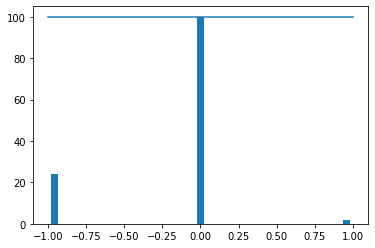

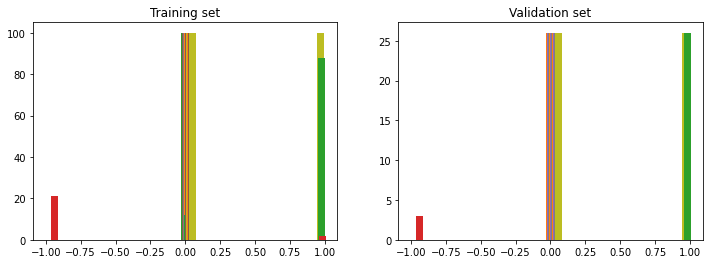

In [51]:
#processed image rgb color - no image filters
file_name = "preprocessed_training_data-5.npy"
num_bins = 25
# full file information
train_data = np.load(file_name,allow_pickle=True)
df_image_clean, df = cleaning_data(train_data,show=True)
X_train, X_valid, y_train, y_valid = train_test_split(df_image_clean, df, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(y_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05)
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05)
axes[1].set_title('Validation set')
# Train Image part ( 4 Dimensional)
X_image = np.array([df_to_numpy_image(X_train,i) for i in X_train.index])
X=X_image.reshape(-1,WIDTH,HEIGHT,3)
#Train Input part ( 1 Dimensional )
Y = [df_to_numpy_input(y_train,i) for i in y_train.index]
# Test Image part ( 4 Dimensional)
test_image = np.array([df_to_numpy_image(X_valid,i) for i in X_valid.index])
test_x=test_image.reshape(-1,WIDTH,HEIGHT,3)
## Test Input part( 1 Dimensional )
test_y = [df_to_numpy_input(y_valid,i) for i in y_valid.index]

## Testing LX to the left

Let us choose a picture where was used lx

In [56]:
# selecting rows based on condition LX to the left
y_train.loc[y_train[13] < 0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
103,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


        0
W       0
S       0
A       0
D       0
WA      0
WD      0
SA      0
SD      0
 NOKEY  1
LT      0
RT      0
Lx      0
Ly      0
Rx     -1
Ry      0
UP      0
DOWN    0
LEFT    0
RIGHT   0
START   0
SELECT  0
L3      0
R3      0
LB      0
RB      0
A       0
B       0
X       0
Y       0


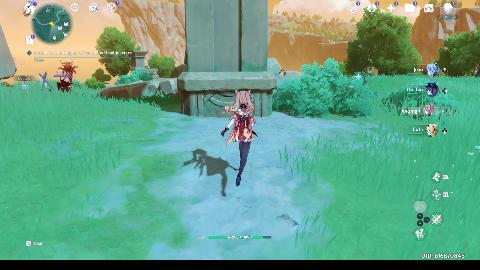

In [110]:
show_action(X_train,y_train,107)

In [ ]:
Let us take this last picture

In [111]:
image107=df_to_numpy_image(X_train,107)

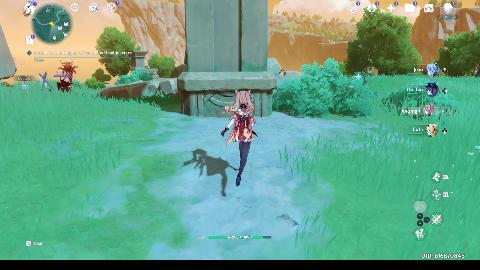

In [112]:
showarray(image107)

In [113]:
image107.shape

(270, 480, 3)

In [114]:
image107.reshape(WIDTH,HEIGHT,3).shape

(480, 270, 3)

In [115]:
def prediction(image):
    initial_shape=(270, 480, 3)
    #The image input should be numpy image with  (270, 480, 3) shape
    assert image.shape == initial_shape, "The numpy image shape should be (270, 480, 3)"
    #We have to  Reshape to (480, 270, 3)
    imager=image.reshape(WIDTH,HEIGHT,3)
    prediction = model.predict([imager])[0]
    prediction=prediction.round(decimals=2, out=None)
    prediction = np.array(prediction) * np.array([4.5, 0.1, 0.1, 0.1,  1.8,   1.8, 0.5, 0.5, 0.2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
    dato=np.array([prediction])
    columna=['W', 'S', 'A', 'D', 'WA', 'WD', 'SA', 'SD',' NOKEY','LT', 'RT', 'Lx', 'Ly', 'Rx', 'Ry', 'UP', 'DOWN', 'LEFT', 'RIGHT',
           'START', 'SELECT', 'L3', 'R3', 'LB', 'RB', 'A', 'B', 'X', 'Y']
    df_pred = pd.DataFrame(dato,columns=columna)
    df_pred_transposed = df_pred.T
    print(df_pred_transposed)

In [116]:
prediction(image107)

            0
W       0.000
S       0.000
A       0.000
D       0.000
WA      0.000
WD      0.000
SA      0.000
SD      0.000
 NOKEY  0.098
LT      0.000
RT      0.000
Lx      0.000
Ly      0.490
Rx      0.000
Ry      0.000
UP      0.000
DOWN    0.000
LEFT    0.000
RIGHT   0.000
START   0.000
SELECT  0.000
L3      0.000
R3      0.000
LB      0.000
RB      0.000
A       0.000
B       0.000
X       0.000
Y       0.000


## Testing LX to the right

In [117]:
# selecting rows based on condition LX to the right
y_train.loc[y_train[13] > 0]

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
21,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


        0
W       0
S       0
A       0
D       0
WA      0
WD      0
SA      0
SD      0
 NOKEY  1
LT      0
RT      0
Lx      0
Ly      1
Rx      1
Ry      0
UP      0
DOWN    0
LEFT    0
RIGHT   0
START   0
SELECT  0
L3      0
R3      0
LB      0
RB      0
A       0
B       0
X       0
Y       0


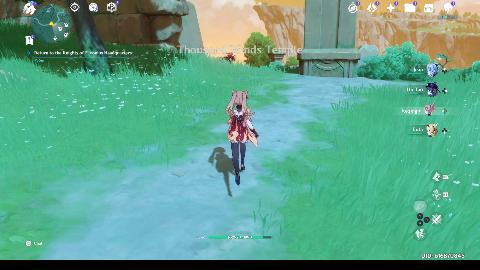

In [118]:
show_action(X_train,y_train,106)

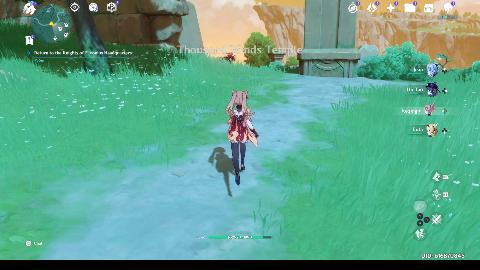

In [120]:
image106=df_to_numpy_image(X_train,106)
showarray(image106)

In [121]:
prediction(image106)

           0
W       0.00
S       0.00
A       0.00
D       0.00
WA      0.00
WD      0.00
SA      0.00
SD      0.00
 NOKEY  0.10
LT      0.00
RT      0.00
Lx      0.00
Ly      0.48
Rx      0.00
Ry      0.00
UP      0.00
DOWN    0.00
LEFT    0.00
RIGHT   0.00
START   0.00
SELECT  0.00
L3      0.00
R3      0.00
LB      0.00
RB      0.00
A       0.00
B       0.00
X       0.00
Y       0.00


The next step is call the gampad to execute this action.

In [35]:
def action(mode_choice):
    #mode_choise : Input number from 0 to 28
    #KEYBOARD INPUT
    if mode_choice == 0:
        straight()
        choice_picked = 'straight'
    elif mode_choice == 1:
        reverse()
        choice_picked = 'reverse'
    elif mode_choice == 2:
        left()
        choice_picked = 'left'
    elif mode_choice == 3:
        right()
        choice_picked = 'right'
    elif mode_choice == 4:
        forward_left()
        choice_picked = 'forward+left'
    elif mode_choice == 5:
        forward_right()
        choice_picked = 'forward+right'
    elif mode_choice == 6:
        reverse_left()
        choice_picked = 'reverse+left'
    elif mode_choice == 7:
        reverse_right()
        choice_picked = 'reverse+right'
    elif mode_choice == 8:
        no_keys()
        choice_picked = 'nokeys'
    #GAMEPAD INPUT                
    elif mode_choice == 9:
        gamepad_lt()
        choice_picked ='LT'
    elif mode_choice == 10:
        gamepad_rt()
        choice_picked ='RT'
    elif mode_choice == 11:
        if val_prediction < 0:
            game_lx_left()
            choice_picked ='Lx'
        else:
            game_lx_right()
            choice_picked ='Lx'
    elif mode_choice == 12:
        if val_prediction < 0:
            game_ly_down()
            choice_picked ='Ly'
        else:
            game_ly_up()
            choice_picked ='Ly'   
    elif mode_choice == 13:
        if val_prediction < 0:
            look_rx_left()
            choice_picked ='Rx'
        else:
            look_rx_right()
            choice_picked ='Rx'  
    elif mode_choice == 14:
        if val_prediction < 0:
            look_ry_down()
            choice_picked ='Ry'
        else:
            look_ry_up()
            choice_picked ='Ry'                 
    elif mode_choice == 15:
        #To be defined
        choice_picked ='UP'
    elif mode_choice == 16:
        #To be defined
        choice_picked ='DOWN'               
    elif mode_choice == 17:
        #To be defined
        choice_picked ='LEFT'
    elif mode_choice == 18:
        #To be defined
        choice_picked ='RIGHT'
    elif mode_choice == 19:
        #To be defined
        choice_picked ='START'
    elif mode_choice == 20:
        #To be defined
        choice_picked ='SELECT'
    elif mode_choice == 21:
        #To be defined
        choice_picked ='L3'
    elif mode_choice == 22:
        #To be defined
        choice_picked ='R3'
    elif mode_choice == 23:
        #To be defined
        choice_picked ='LB'
    elif mode_choice == 24:
        #To be defined
        choice_picked ='RB'
    elif mode_choice == 25:
        button_A()
        choice_picked ='A'
    elif mode_choice == 26:
        button_B()
        choice_picked ='B'
    elif mode_choice == 27:
        button_X()
        choice_picked ='X'
    elif mode_choice == 28:
        button_Y()
        choice_picked ='Y'
    #print(choice_picked)

In [36]:
action(mode_choice)
time.sleep(1)
ultimate_release()

In [37]:
ultimate_release()

In [38]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

# Full code

In [1]:
import numpy as np
import pandas as pd
from grabscreen import grab_screen
import cv2
import time
from directkeys import PressKey,ReleaseKey, W, A, S, D
from models import inception_v3 as googlenet
from getkeys import key_check
from collections import deque, Counter
import random
from statistics import mode,mean
import numpy as np
from motion import motion_detection
#Importing Gamepad library
from vjoy2 import *
#Importing escape library
import msvcrt

GAME_WIDTH = 1920
GAME_HEIGHT = 1080

how_far_remove = 800
rs = (20,15)
log_len = 25

motion_req = 800
motion_log = deque(maxlen=log_len)

WIDTH = 480
HEIGHT = 270
LR = 1e-3
EPOCHS = 1

choices = deque([], maxlen=5)
hl_hist = 250
choice_hist = deque([], maxlen=hl_hist)

w = [1,0,0,0,0,0,0,0,0]
s = [0,1,0,0,0,0,0,0,0]
a = [0,0,1,0,0,0,0,0,0]
d = [0,0,0,1,0,0,0,0,0]
wa = [0,0,0,0,1,0,0,0,0]
wd = [0,0,0,0,0,1,0,0,0]
sa = [0,0,0,0,0,0,1,0,0]
sd = [0,0,0,0,0,0,0,1,0]
nk = [0,0,0,0,0,0,0,0,1]

t_time = 0.25

def straight():
    PressKey(W)
    ReleaseKey(A)
    ReleaseKey(D)
    ReleaseKey(S)

def left():
    if random.randrange(0,3) == 1:
        PressKey(W)
    else:
        ReleaseKey(W)
    PressKey(A)
    ReleaseKey(S)
    ReleaseKey(D)
    #ReleaseKey(S)

def right():
    if random.randrange(0,3) == 1:
        PressKey(W)
    else:
        ReleaseKey(W)
    PressKey(D)
    ReleaseKey(A)
    ReleaseKey(S)
    
def reverse():
    PressKey(S)
    ReleaseKey(A)
    ReleaseKey(W)
    ReleaseKey(D)


def forward_left():
    PressKey(W)
    PressKey(A)
    ReleaseKey(D)
    ReleaseKey(S)
    
    
def forward_right():
    PressKey(W)
    PressKey(D)
    ReleaseKey(A)
    ReleaseKey(S)

    
def reverse_left():
    PressKey(S)
    PressKey(A)
    ReleaseKey(W)
    ReleaseKey(D)

    
def reverse_right():
    PressKey(S)
    PressKey(D)
    ReleaseKey(W)
    ReleaseKey(A)

def no_keys():

    if random.randrange(0,3) == 1:
        PressKey(W)
    else:
        ReleaseKey(W)
    ReleaseKey(A)
    ReleaseKey(S)
    ReleaseKey(D)
    

model = googlenet(WIDTH, HEIGHT, 3, LR, output=29)
MODEL_NAME = 'model/test'
model.load(MODEL_NAME)
print('We have loaded a previous model!!!!')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from C:\Users\rusla\Dropbox\23-GITHUB\Projects\BOT-MMORPG-WITH-AI\versions\0.01\model\test
We have loaded a previous model!!!!


In [2]:
def main():
    aborted = False
    last_time = time.time()
    for i in list(range(4))[::-1]:
        print(i+1)
        time.sleep(1)

    paused = False
    mode_choice = 0

    screen = grab_screen(region=(0,40,GAME_WIDTH,GAME_HEIGHT+40))
    screen = cv2.cvtColor(screen, cv2.COLOR_BGR2RGB)
    prev = cv2.resize(screen, (WIDTH,HEIGHT))

    t_minus = prev
    t_now = prev
    t_plus = prev

    while(True):
        
        if not paused:
            screen = grab_screen(region=(0,40,GAME_WIDTH,GAME_HEIGHT+40))
            screen = cv2.cvtColor(screen, cv2.COLOR_BGR2RGB)

            last_time = time.time()
            screen = cv2.resize(screen, (WIDTH,HEIGHT))
            #print(len(t_minus), len(t_now), len(t_plus))
            delta_count_last = motion_detection(t_minus, t_now, t_plus,screen)
            delta_count=delta_count_last
            
            t_minus = t_now
            t_now = t_plus
            t_plus = screen
            t_plus = cv2.blur(t_plus,(4,4))
            
            
            prediction = model.predict([screen.reshape(WIDTH,HEIGHT,3)])[0]
            prediction=prediction.round(decimals=2, out=None)
            prediction = np.array(prediction) * np.array([4.5, 0.1, 0.1, 0.1,  1.8,   1.8, 0.5, 0.5, 0.2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
            prediction_list=list(prediction)
            #python convert list to absolute value
            result =  [abs(element) for element in prediction_list]
            mode_choice=np.argmax(result)
            val_prediction=prediction_list[mode_choice]
          
            #KEYBOARD INPUT
            if mode_choice == 0:
                straight()
                choice_picked = 'straight'
            elif mode_choice == 1:
                reverse()
                choice_picked = 'reverse'
            elif mode_choice == 2:
                left()
                choice_picked = 'left'
            elif mode_choice == 3:
                right()
                choice_picked = 'right'
            elif mode_choice == 4:
                forward_left()
                choice_picked = 'forward+left'
            elif mode_choice == 5:
                forward_right()
                choice_picked = 'forward+right'
            elif mode_choice == 6:
                reverse_left()
                choice_picked = 'reverse+left'
            elif mode_choice == 7:
                reverse_right()
                choice_picked = 'reverse+right'
            elif mode_choice == 8:
                no_keys()
                choice_picked = 'nokeys'
            #GAMEPAD INPUT                
            elif mode_choice == 9:
                gamepad_lt()
                choice_picked ='LT'
            elif mode_choice == 10:
                gamepad_rt()
                choice_picked ='RT'
            elif mode_choice == 11:
                if val_prediction < 0:
                    game_lx_left()
                    choice_picked ='Lx'
                else:
                    game_lx_right()
                    choice_picked ='Lx'
            elif mode_choice == 12:
                if val_prediction < 0:
                    game_ly_down()
                    choice_picked ='Ly'
                else:
                    game_ly_up()
                    choice_picked ='Ly'   
            elif mode_choice == 13:
                if val_prediction < 0:
                    look_rx_left()
                    choice_picked ='Rx'
                else:
                    look_rx_right()
                    choice_picked ='Rx'  
            elif mode_choice == 14:
                if val_prediction < 0:
                    look_ry_down()
                    choice_picked ='Ry'
                else:
                    look_ry_up()
                    choice_picked ='Ry'                 
            elif mode_choice == 15:
                #To be defined
                choice_picked ='UP'
            elif mode_choice == 16:
                #To be defined
                choice_picked ='DOWN'               
            elif mode_choice == 17:
                #To be defined
                choice_picked ='LEFT'
            elif mode_choice == 18:
                #To be defined
                choice_picked ='RIGHT'
            elif mode_choice == 19:
                #To be defined
                choice_picked ='START'
            elif mode_choice == 20:
                #To be defined
                choice_picked ='SELECT'
            elif mode_choice == 21:
                #To be defined
                choice_picked ='L3'
            elif mode_choice == 22:
                #To be defined
                choice_picked ='R3'
            elif mode_choice == 23:
                #To be defined
                choice_picked ='LB'
            elif mode_choice == 24:
                #To be defined
                choice_picked ='RB'
            elif mode_choice == 25:
                button_A()
                choice_picked ='A'
            elif mode_choice == 26:
                button_B()
                choice_picked ='B'
            elif mode_choice == 27:
                button_X()
                choice_picked ='X'
            elif mode_choice == 28:
                button_Y()
                choice_picked ='Y'
                
         

            motion_log.append(delta_count)
            motion_avg = round(mean(motion_log),3)
            print('loop took {} seconds. Motion: {}. Choice: {}'.format( round(time.time()-last_time, 3) , motion_avg, choice_picked))
            
            if motion_avg < motion_req and len(motion_log) >= log_len:
                print('WERE PROBABLY STUCK FFS, initiating some evasive maneuvers.')

                # 0 = reverse straight, turn left out
                # 1 = reverse straight, turn right out
                # 2 = reverse left, turn right out
                # 3 = reverse right, turn left out

                quick_choice = random.randrange(0,4)
                
                if quick_choice == 0:
                    reverse()
                    time.sleep(random.uniform(1,2))
                    forward_left()
                    time.sleep(random.uniform(1,2))

                elif quick_choice == 1:
                    reverse()
                    time.sleep(random.uniform(1,2))
                    forward_right()
                    time.sleep(random.uniform(1,2))

                elif quick_choice == 2:
                    reverse_left()
                    time.sleep(random.uniform(1,2))
                    forward_right()
                    time.sleep(random.uniform(1,2))

                elif quick_choice == 3:
                    reverse_right()
                    time.sleep(random.uniform(1,2))
                    forward_left()
                    time.sleep(random.uniform(1,2))

                for i in range(log_len-2):
                    del motion_log[0]
    
        keys = key_check()
        
        
# First of all, check if ESCape was pressed
        if msvcrt.kbhit() and ord(msvcrt.getch()) == 27:
            aborted = True
            break
        

        # p pauses game and can get annoying.
        if 'T' in keys:
            if paused:
                paused = False
                time.sleep(1)
            else:
                paused = True
                ReleaseKey(A)
                ReleaseKey(W)
                ReleaseKey(D)
                time.sleep(1)
    if aborted:
        ultimate_release()
        print("Program was aborted")

To abort the code, go to your command prompt terminal where your notebook where opened, and there you can press "ESC" to abort the program or "T" pause the AI  program.

Things to do before run the main()
1. **Open your  Genshin Impact Game**
2. **Go to the bridge of Mondstat**
![title](img/step-0.png)
3. **Change the time to 12:00**
![title](img/step-1.png)
4. **Verify that you are using your controller.**
![title](img/step-2.png)
5. **Run the main()**
6. **Return to the windows of your game**

<center>
<video width="620" height="440" src="img/video.mp4" type="video/mp4" controls>
</video>
</center>

In [6]:
import os

In [49]:
# Path
path = os.getcwd()
# Join various path components
app=os.path.join(path, "vjoy-gamepad", "JoystickTest.exe")
#print(app)

In [48]:
import os
#os.startfile("C:\BOT-MMORPG-WITH-AI\versions\0.01\vjoy-gamepad\JoystickTest.exe")
os.startfile(app)

![title](img/step-3.png)

To run just run the main cell below:

In [3]:
main()

4
3
2
1
loop took 13.649 seconds. Motion: 0. Choice: Ly
loop took 0.058 seconds. Motion: 6614.5. Choice: Ly
loop took 0.058 seconds. Motion: 9659. Choice: Ly
loop took 0.071 seconds. Motion: 8556.75. Choice: Ly
loop took 0.062 seconds. Motion: 7431.6. Choice: Ly
loop took 0.067 seconds. Motion: 6693.333. Choice: Ly
loop took 0.054 seconds. Motion: 6159. Choice: Ly
loop took 0.054 seconds. Motion: 5723.375. Choice: Ly
loop took 0.06 seconds. Motion: 5380.333. Choice: Ly
loop took 0.054 seconds. Motion: 5125.9. Choice: Ly
loop took 0.053 seconds. Motion: 4943.636. Choice: Ly
loop took 0.052 seconds. Motion: 4806.75. Choice: Ly
loop took 0.065 seconds. Motion: 4680.231. Choice: Ly
loop took 0.052 seconds. Motion: 4551.571. Choice: Ly
loop took 0.056 seconds. Motion: 4439.933. Choice: Ly
loop took 0.069 seconds. Motion: 4334.562. Choice: Ly
loop took 0.062 seconds. Motion: 4216.353. Choice: Ly
loop took 0.055 seconds. Motion: 4097.889. Choice: Ly
loop took 0.054 seconds. Motion: 3972.842. 